In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import joblib
import pickle
import json
from collections import defaultdict
import seaborn as sns

In [2]:
### train data loading and preprocessing ###
## concatenating observations in the same group
data_dict = {} # separate data by .txt file

directory = 'IMU-train'

for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    
    if filename.endswith('.txt'):
        data = np.loadtxt(filepath, delimiter='\t')  
                
        if filename[:5] == "beat3":
            key = "beat3"
        elif filename[:5] == "beat4":
            key = "beat4"
        elif filename[:6] == "circle":
            key = "circle"
        elif filename[:5] == "eight":
            key = "eight"
        elif filename[:3] == "inf":
            key = "inf"
        elif filename[:4] == "wave":
            key = "wave"

        if key in data_dict:
            data_dict[key] = np.concatenate((data_dict[key], data), axis=0)
        else:
            data_dict[key] = data

        # concatenate data
    else:
        raise Exception('non-.txt file in training folder')

print(data_dict.keys())

dict_keys(['wave', 'circle', 'eight', 'inf', 'beat4', 'beat3'])


In [3]:
### Plotting functions ######

def plot_training_curve(likelihood_list, motion, M, S):
    plt.figure(figsize=(10, 6))  # Set the figure size for better readability
    plt.plot(likelihood_list, marker='o', linestyle='-', color='blue') 
    plt.title(f'Training Curve of Likelihood Estimates of {motion} with {M} observation clusters and {S} hidden states')
    plt.xlabel('Epoch')
    plt.ylabel('Log-Likelihood Estimate')
    plt.grid(True)  # Show grid for better readability
    plt.savefig(f'IMU-train-visuals/TrainingCurves/training_curve_{motion}_{M}clusters_{S}states.png')

In [4]:
### scaled forward calculation function
def scaled_forward(pi, A, B, O):
    """    
    A: Transition probabilities, shape(S, S), A_ij is prob from i to j
    B: Emission probabilities, shape(S, M)
    pi: Initial state probabilities, shape(S,)
    O: observation sequence, shape(T,)
    """
    # S = len(A[0])
    # T = len(O) # sequence length
    # # Initialize alpha matrix
    # alpha = np.zeros((num_observations, S))
    
    # # Base case
    # alpha[0, :] = pi * B[:, observations[0]]

    # for t in range(len(O)):
    num_observations = len(O)
    num_states = A.shape[0]

    # print("pi: ", pi)
    # print(B[:, O[0]])
    # Initialize forward probabilities matrix
    alpha = np.zeros((num_observations, num_states), dtype=np.float64)
    # Initialize scaling factors
    c = np.zeros(num_observations, dtype=np.float64)
    
    # Base case with scaling
    # print("pi: ", pi)
    # print("B: ", B)
    # print("O[0]: ", O[0])
    # print("B[:, O[0]]: ", B[:, O[0]])
    alpha[0, :] = pi * B[:, O[0]] # make sure to multiply pi by B
    # alpha[0, :] = pi # NOTE: slides might be wrong here
    # print(alpha[0, :])
    c[0] = 1 / np.sum(alpha[0, :])
    alpha[0, :] *= c[0]
    # print("c[0]: ", c[0])
    # print(alpha[0, :])

    
    # print(alpha[0, :].shape)
    # Recursive step with scaling
    for t in range(1, num_observations):
        # slower version
        # for j in range(num_states):
        #     alpha[t, j] = np.dot(alpha[t-1, :], A[:, j]) * B[j, O[t]]

        # faster version w/ matmul
        new = (alpha[t-1, :].reshape(1, -1) @ A) * B[:, O[t]]
        # print("new shape: ", new.shape)
        # print("new: ", new)
        alpha[t, :] = new.flatten()

        # scaling
        c[t] = 1 / np.sum(alpha[t, :])
        # print("c shape:", c.shape)
        # print("c: ", c)
        alpha[t, :] *= c[t]
    
    # log probability of the observation sequence using scaling factors, for prediction and checking for convergence
    log_prob_observation = -np.sum(np.log(c))
    
    return alpha, c, log_prob_observation

### scaled forward calculation function
def scaled_backward(A, B, c, O):
    """    
    A: Transition probabilities, shape(S, S), A_ij is prob from i to j
    B: Emission probabilities, shape(S, M)
    c: scaling coefficients from forward
    O: observation sequence, shape(T,)
    """
    num_observations = len(O)
    num_states = A.shape[0]
    
    # TODO: figure out correct initialization
    beta = np.zeros((num_observations, num_states), dtype=np.float64)
    beta[num_observations-1, :] = c[num_observations-1] # NOTE: this might be incorrect, but i think correct
    # print("beta after base case: ", beta)

    # Recursive step with scaling
    for t in range(num_observations-2, -1, -1):
        # # slower version
        # for past in range(num_states):
        #     # TODO: check indexing on this
        #     beta[t, past] = np.sum(A[past, :] * B[:, O[t+1]] * beta[t+1, :])
        # beta[t, :] *= c[t]

        # faster version with matmul
        # NOTE: not sure on this reshaping
        Bs = (B[:, O[t+1]] * beta[t+1, :]).reshape(1, -1)
        # print("Bs.shape: ", Bs.shape)
        new = (Bs @ A.T) * c[t]
        # print("new shape: ", new.shape)
        # print("new: ", new)
        beta[t, :] = new.flatten()
    
    return beta

In [6]:
### E Step ####
def e_step(A, B, alpha, beta, O):
    """
    A: Transition probabilities, shape (S, S)
    B: Emission probabilities, shape (S, M)
    alpha: Forward probabilities, shape (T, S)
    beta: Backward probabilities, shape (T, S)
    O: Observation sequence, shape (T,)
    """
    S = A.shape[0]
    T = len(O)

    # Compute gamma
    ab = alpha * beta
    g_denom = np.sum(ab, axis=1, keepdims=True)
    # print("gamma denom: ", g_denom) # NOTE: do I need this denom?
    gamma = ab / g_denom # this could also probs be done with np.avg

    # compute xi
    xi = np.zeros((T-1, S, S))

    for t in range(T-1): # is there a way to get rid of this loop?
        # if t==0:
            # print("alpha[t, :, None] shape: ", alpha[t, :, None].shape)
            # print("beta[t+1, None, :] shape: ", beta[t+1, None, :].shape)
        xi_num = alpha[t, :, None] * A * B[:, O[t+1]] * beta[t+1, None, :]
        xi_denom = xi_num.sum()
        # print("xi denom: ", xi_denom)
        xi[t, :, :] = xi_num / xi_denom

    return gamma, xi

def e_step_scaled(A, B, alpha, beta, c, O):
    """
    A: Transition probabilities, shape (S, S)
    B: Emission probabilities, shape (S, M)
    alpha: Forward probabilities, shape (T, S)
    beta: Backward probabilities, shape (T, S)
    c: scaling coefficients from forward
    O: Observation sequence, shape (T,)
    """
    S = A.shape[0]
    T = len(O)

    # Compute gamma
    ab = alpha * beta
    g_denom = c.reshape(-1, 1) # divide numerator by scaling coefficient
    print("c.shape: ", c.shape)
    assert g_denom.shape == (T, 1)
    gamma = ab / g_denom

    # compute xi
    xi = np.zeros((T-1, S, S))

    for t in range(T-1): # is there a way to get rid of this loop?
        # if t==0:
            # print("alpha[t, :, None] shape: ", alpha[t, :, None].shape)
            # print("beta[t+1, None, :] shape: ", beta[t+1, None, :].shape)
        xi_num = alpha[t, :, None] * A * B[:, O[t+1]] * beta[t+1, None, :]
        xi[t, :, :] = xi_num

    return gamma, xi

In [7]:
### M-step ###

def m_step(gamma, xi, O, M):
    """
    gamma: State occupancy probabilities, shape (T, S)
    xi: ______ probabilities, shape (T-1, S, S)
    O: Observation sequence, shape (T,)
    M: Number of unique observation symbols
    """
    S = gamma.shape[1]  # Number of states
    # T = len(O)  # Length of observation sequence

    # Update transition matrix A
    # NOTE: FOR REPORT SUBMISSION, I transposed the previous denominator to make the broadcasting to recalculate A correct 
    A_denom = np.sum(gamma[:-1], axis=0, keepdims=True).T
    # print("A_denom.shape: ", A_denom.shape)
    assert A_denom.shape == (xi.shape[1], 1)
    # print("A_denom: ", A_denom)
    A = np.sum(xi, axis=0) / A_denom

    # Update emission matrix B
    B = np.zeros((S, M))
    for j in range(M):
        mask = (O == j)
        # print("gamma[mask]: ", gamma[mask])
        B[:, j] = np.sum(gamma[mask], axis=0) / np.sum(gamma, axis=0)

    return A, B

In [8]:
### General BM function

def baum_welch(O, S, M, max_epochs=30, tolerance=1e-6, plot_data=False, motion="INSERT MOTION", B_smoothing=True):
    """
    O: Observation sequence, shape (T,)
    S: Number of states in the HMM.
    M: Number of observation symbols/ kmeans clusters
    """
    likelihood_list = []
    # init transition_matrix A for left-to-right HMM
    # NOTE: for this matrix, the start matrix is the row index and the end matrix is the column index
    transition_matrix = np.zeros((S, S), dtype=np.float64)
    for i in range(S):
        transition_matrix[i, i] = 0.9
        if i == S - 1:
            # last state, allow transition back to the first state
            transition_matrix[i, 0] = 0.1
        else:
            transition_matrix[i, i + 1] = 0.1

    # make sure transition matrices rows add up to 1
    assert np.all(np.isclose(np.sum(transition_matrix, axis=1), 1))

    # initial state distribution pi
    init_st_distribution = np.zeros(S, dtype=np.float64)
    init_st_distribution[0] = 1.0

    # initial emission probabilities from each state
    emission_probs = np.ones((S, M), dtype=np.float64) / M

    prev_log_prob = -np.inf

    for epoch in range(max_epochs):
        print(f"\nEpoch ", epoch, "\n")

        ## Forward-Backward calculataions
        alpha, c, log_prob = scaled_forward(pi=init_st_distribution, A=transition_matrix, B=emission_probs, O=O)
        # print("alpha shape: ", alpha.shape)
        # print("c shape: ", c.shape)
        # print("c: ", c)
        # print("log_prob: ", log_prob)

        likelihood_list.append(log_prob)

        beta = scaled_backward(A=transition_matrix, B=emission_probs, c=c, O=O)
        # print("beta: ", beta)

        # Check for convergence
        if epoch > 0 and np.abs(log_prob - prev_log_prob) < tolerance:
            print(f"Converged at epoch {epoch}.")
            break
        prev_log_prob = log_prob

        ### E-Step
        # print(f"\nE-step\n")
        # gamma, xi = e_step(A=transition_matrix, B=emission_probs, alpha=alpha, beta=beta, O=O)
        gamma, xi = e_step_scaled(A=transition_matrix, B=emission_probs, alpha=alpha, beta=beta, c=c, O=O)
        # print("gamma.shape: ", gamma.shape)
        # print("xi.shape: ", xi.shape)

        ### M-step
        # print(f"\nM-step\n")
        transition_matrix, emission_probs = m_step(gamma=gamma, xi=xi, O=O, M=M)
        # print("transition_matrix.shape: ", transition_matrix.shape)
        # print("transition_matrix: ", transition_matrix)
        # print("emission_probs.shape: ", emission_probs.shape)

        # make sure transition matrices rows add up to 1
        # assert np.all(np.isclose(np.sum(transition_matrix, axis=1), 1))

    # plot training curve
    if plot_data:
        plot_training_curve(likelihood_list, motion, M, S)

    # add 1e-8 to emission probs to prevent trajectories with 0 probability
    if B_smoothing:
        emission_probs += 1e-8

    # return A, B, pi
    return transition_matrix, emission_probs, init_st_distribution, likelihood_list[-1]

In [ ]:
# #### Apply BM algorithm to training data for single cluster and number of states
# S = 15 # Number of Hidden States
# tolerance = 1e-6
# num_epochs = 30

# models_dict = {}

# for motion, data in data_dict.items():
#     print(motion)
#     # if motion == "wave":
#     #     continue # here for now to skip wave
#     ### get observations/emissions for data with kmeans model
#     input_emissions = kmeans_model.predict(data[:, 1:])
#     print(input_emissions)
    
#     # train HMM model
#     transition_matrix, emission_probs, init_st_distribution, _ = baum_welch(O=input_emissions, S=S, M=M, max_epochs=num_epochs, tolerance=tolerance, plot_data=True, motion=motion)

#     # save the model to dictionary
#     models_dict[motion] = (transition_matrix, emission_probs, init_st_distribution)
#     # break # here for now to just test on one

# print(models_dict.keys())
# print("done!")

In [9]:
#### Apply BM algorithm to training data FOR DIFFERENT HYPERPARAMETER SIZES for GRID SEARCH ####
tolerance = 1e-6
num_epochs = 30

hyperparam_models_dict = {}

log_likelihoods_dict = {}

Cluster_sizes = [50, 60, 70, 80, 90, 100]
State_sizes = [10, 12, 14, 16, 18, 20]
Kmeans_models_GS = {}

for M in Cluster_sizes:
    kmeans_fn = f'kmeans_model_{M}.pkl'
    Kmeans_models_GS[M] = joblib.load(f'Kmeans-models/{kmeans_fn}')

for motion, data in data_dict.items():
    print(motion)
    print('\n')
    hyperparam_models_dict[motion] = {}
    log_likelihoods_dict[motion] = {}
    for M in Cluster_sizes:
        print(f'\n{M} Clusters: \n')
        hyperparam_models_dict[motion][M] = {}
        log_likelihoods_dict[motion][M] = {}
        km_model_gs = Kmeans_models_GS[M]
        for S in State_sizes:
            print(f'\n{M} Clusters and {S} States: \n')
            ### get observations/emissions for data with kmeans model
            input_emissions = km_model_gs.predict(data[:, 1:])
            print(input_emissions)
            
            # train HMM model
            transition_matrix, emission_probs, init_st_distribution, log_likelihood = baum_welch(O=input_emissions, S=S, M=M, max_epochs=num_epochs, tolerance=tolerance, plot_data=False, motion=motion)

            # save the model to dictionary
            hyperparam_models_dict[motion][M][S] = (transition_matrix, emission_probs, init_st_distribution)

            # save likelihood
            log_likelihoods_dict[motion][M][S] = log_likelihood

            # break # here for now to just test on one

print("done!")

wave



50 Clusters: 


50 Clusters and 10 States: 

[1 1 1 ... 1 1 1]

Epoch  0 

c.shape:  (14530,)

Epoch  1 

c.shape:  (14530,)

Epoch  2 

c.shape:  (14530,)

Epoch  3 

c.shape:  (14530,)

Epoch  4 

c.shape:  (14530,)

Epoch  5 

c.shape:  (14530,)

Epoch  6 

c.shape:  (14530,)

Epoch  7 

c.shape:  (14530,)

Epoch  8 

c.shape:  (14530,)

Epoch  9 

c.shape:  (14530,)

Epoch  10 

c.shape:  (14530,)

Epoch  11 

c.shape:  (14530,)

Epoch  12 

c.shape:  (14530,)

Epoch  13 

c.shape:  (14530,)

Epoch  14 

c.shape:  (14530,)

Epoch  15 

c.shape:  (14530,)

Epoch  16 

c.shape:  (14530,)

Epoch  17 

c.shape:  (14530,)

Epoch  18 

c.shape:  (14530,)

Epoch  19 

c.shape:  (14530,)

Epoch  20 

c.shape:  (14530,)

Epoch  21 

c.shape:  (14530,)

Epoch  22 

c.shape:  (14530,)

Epoch  23 

c.shape:  (14530,)

Epoch  24 

c.shape:  (14530,)

Epoch  25 

c.shape:  (14530,)

Epoch  26 

c.shape:  (14530,)

Epoch  27 

c.shape:  (14530,)

Epoch  28 

c.shape:  (14530,)

Epoch  29 

In [10]:
print(log_likelihoods_dict.keys())

dict_keys(['wave', 'circle', 'eight', 'inf', 'beat4', 'beat3'])


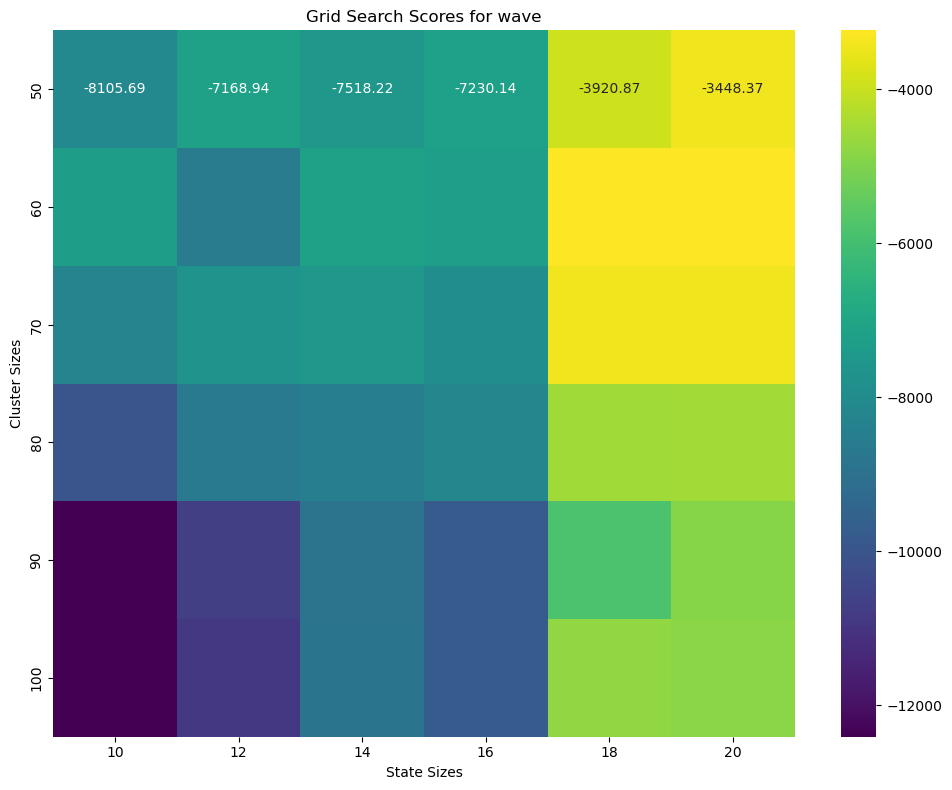

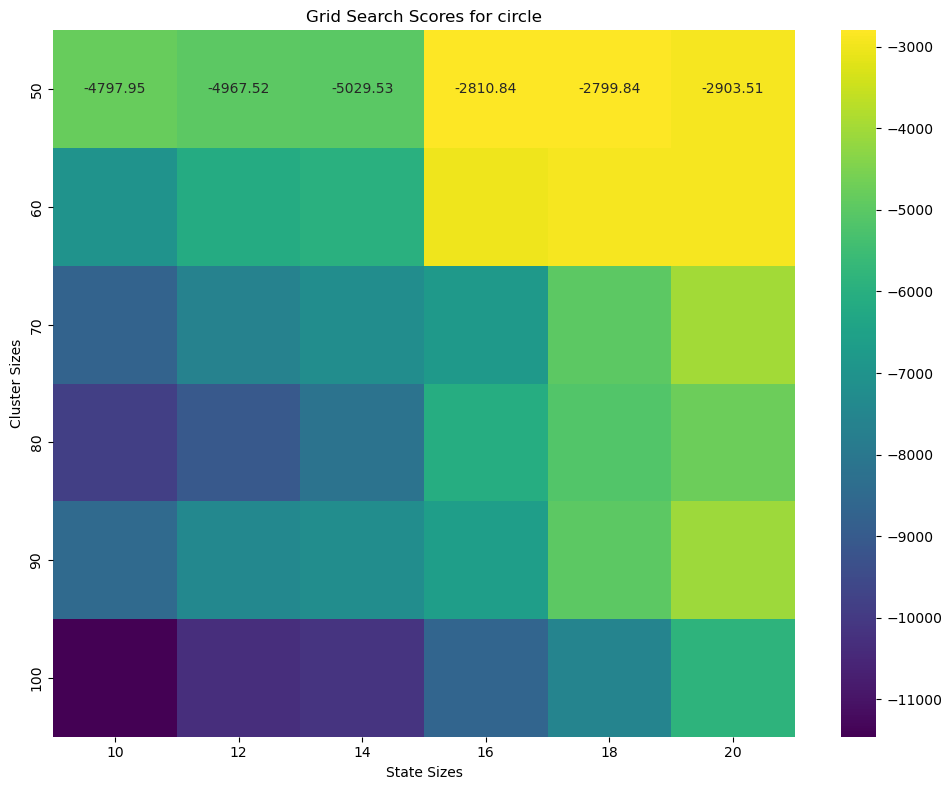

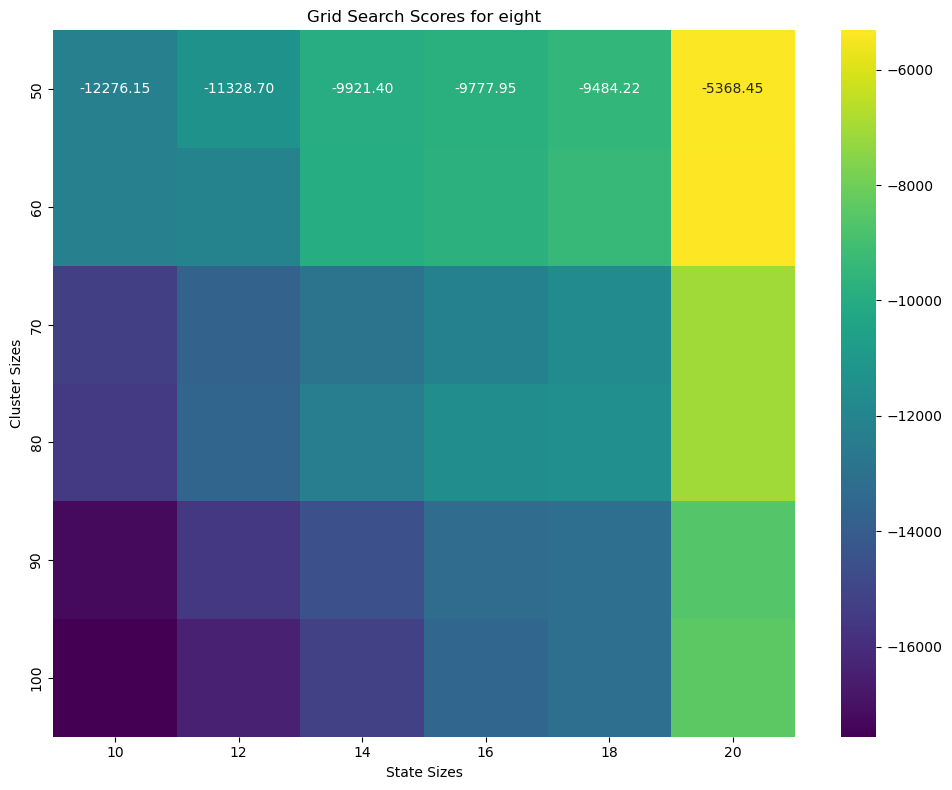

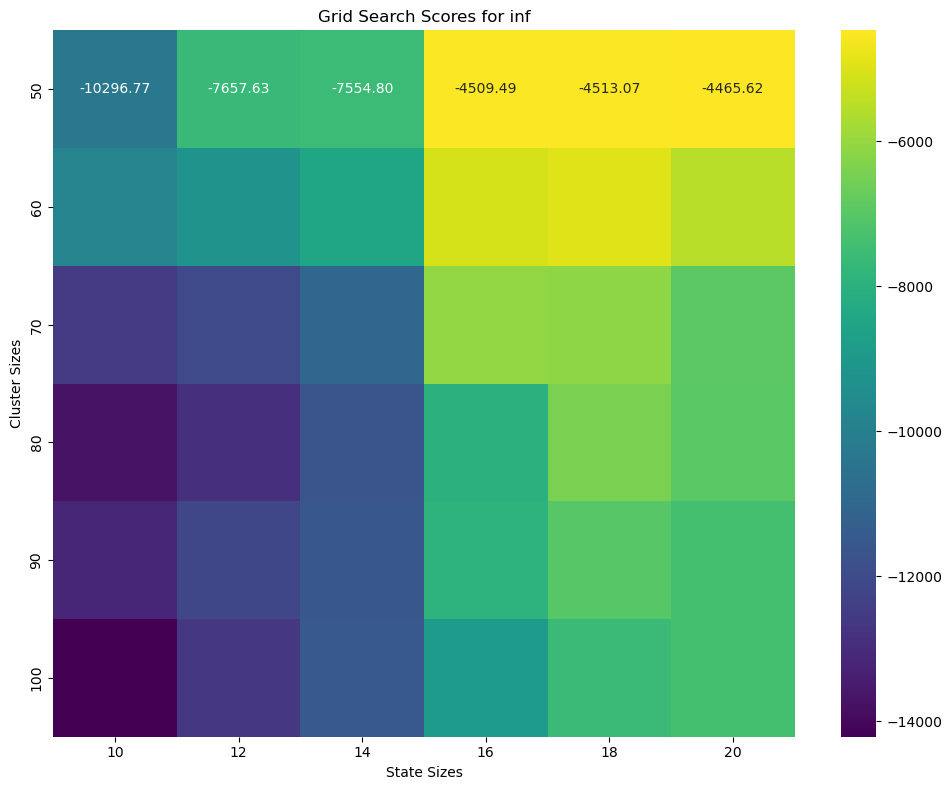

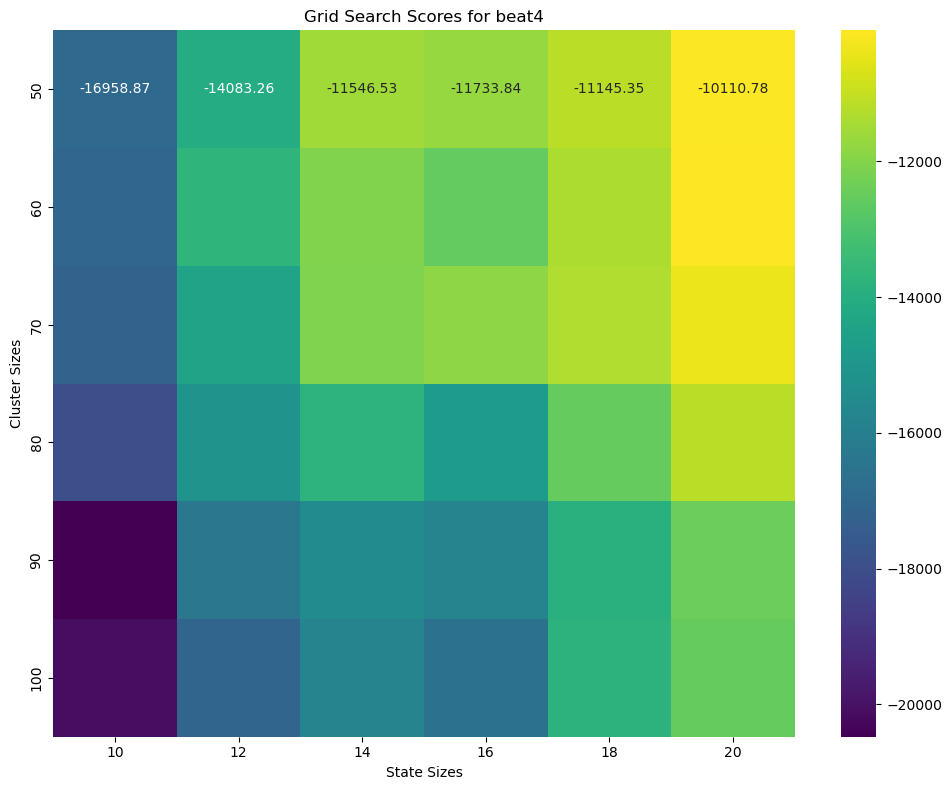

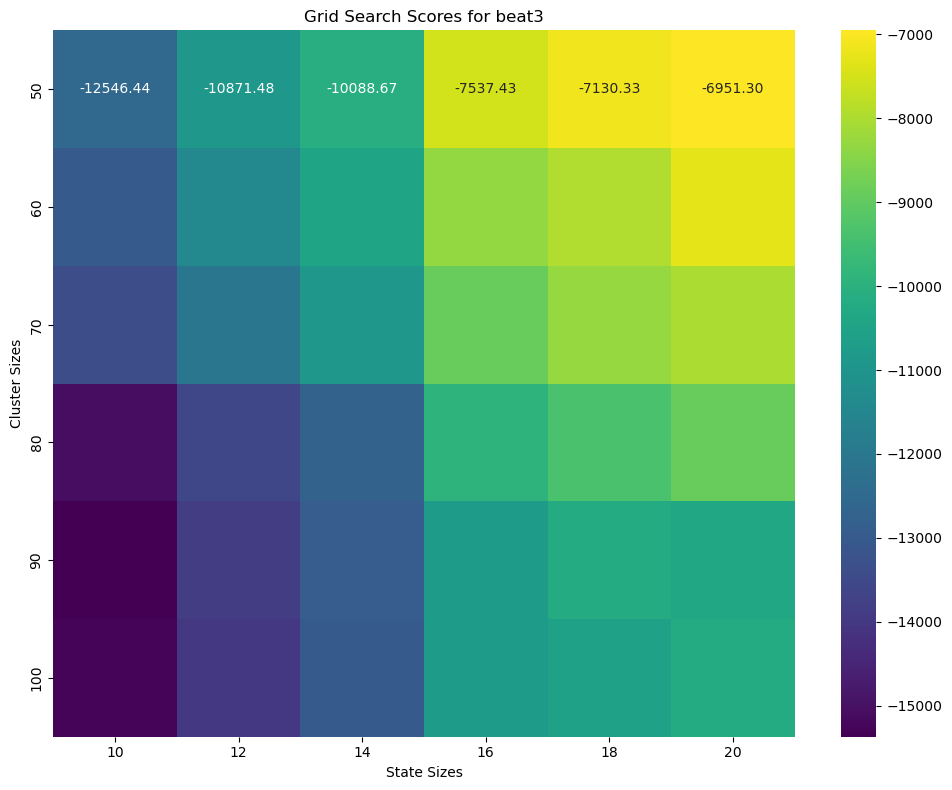

In [13]:
#### Grid search over M and S hyperparams plotting over TRAIN scores ####
# used https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap and seaborn docs as reference
for motion, lld_motion in log_likelihoods_dict.items():
    cluster_sizes = sorted(lld_motion.keys())
    state_sizes = sorted(set(key for subdict in lld_motion.values() for key in subdict))

    # Initialize 2D array for scores
    scores = np.zeros((len(cluster_sizes), len(state_sizes)))

    # Populate 2D array with scores
    for i, cluster_size in enumerate(cluster_sizes):
        for j, state_size in enumerate(state_sizes):
            scores[i, j] = lld_motion[cluster_size].get(state_size, np.nan) # Use np.nan for missing values
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(scores, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=state_sizes, yticklabels=cluster_sizes, ax=ax)
    ax.set_title(f"Grid Search Scores for {motion}")
    ax.set_xlabel("State Sizes")
    ax.set_ylabel("Cluster Sizes")
    plt.tight_layout()
    plt.savefig(f'IMU-train-visuals/Grid-Search/{motion}_Train_gridsearch.png')

In [11]:
#### log-likelihood for prediction #####
def predict_log_likelihood(A, B, pi, O):
    """
    Predict log-likelihood for scaled forward pass using trick on page 273 of Rabiner
    """
    # Run the forward algorithm with scaling
    _, _, log_likelihood = scaled_forward(A=A, B=B, pi=pi, O=O)
    
    return log_likelihood

In [12]:
## load val data
val_emissions = {} # separate data by .txt file

val_emissions_gridsearch = defaultdict(dict)

val_directory = 'IMU-train-additional'

for filename in os.listdir(val_directory):
    filepath = os.path.join(val_directory, filename)
    
    if filename.endswith('.txt'):
        data = np.loadtxt(filepath, delimiter='\t')  
                
        print(filename + ':')
        ## UNCOMMENT FOR NON GRID SEARCH WORK
        # print(data.shape)
        # emissions = kmeans_model.predict(data[:, 1:])
        # print(emissions.shape)
        # val_emissions[filename] = emissions
        
        # for grid search
        for M, km in Kmeans_models_GS.items():
            M_emission = km.predict(data[:, 1:])
            if filename[:5] == "beat3":
                key = "beat3"
            elif filename[:5] == "beat4":
                key = "beat4"
            elif filename[:6] == "circle":
                key = "circle"
            elif filename[:5] == "eight":
                key = "eight"
            elif filename[:3] == "inf":
                key = "inf"
            elif filename[:4] == "wave":
                key = "wave"
            
            val_emissions_gridsearch[M][key] = M_emission
            assert np.max(M_emission) < M
    else:
        raise Exception('non-.txt file in training folder')    

circle31.txt:
beat3_31.txt:
inf31.txt:
beat4_31.txt:
eight31.txt:
wave31.txt:


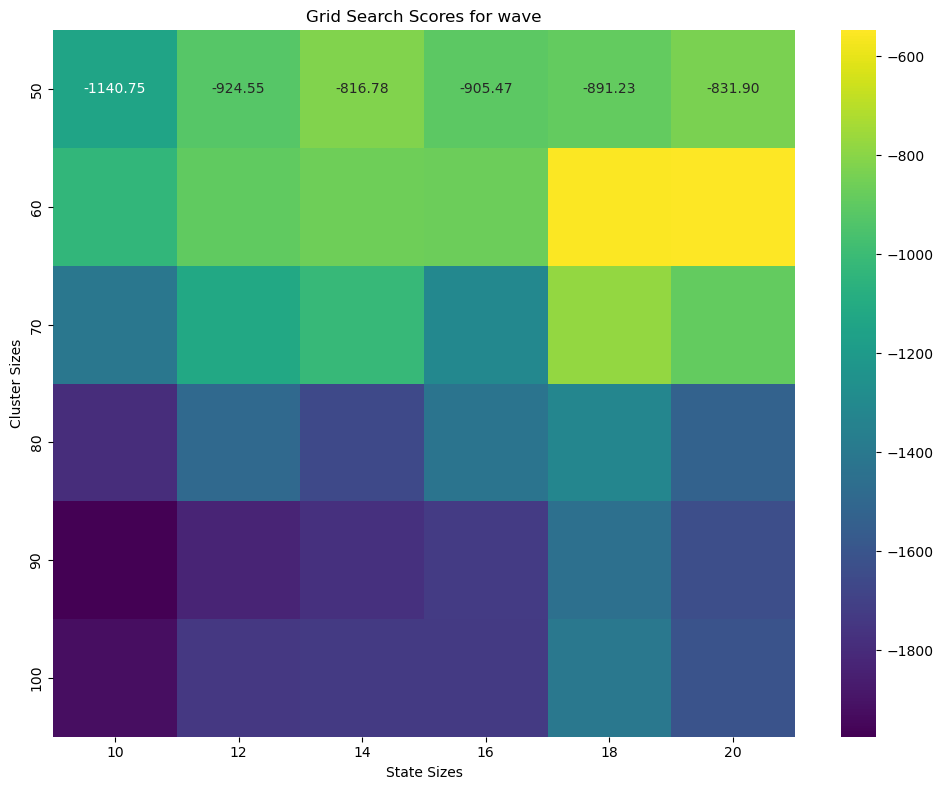

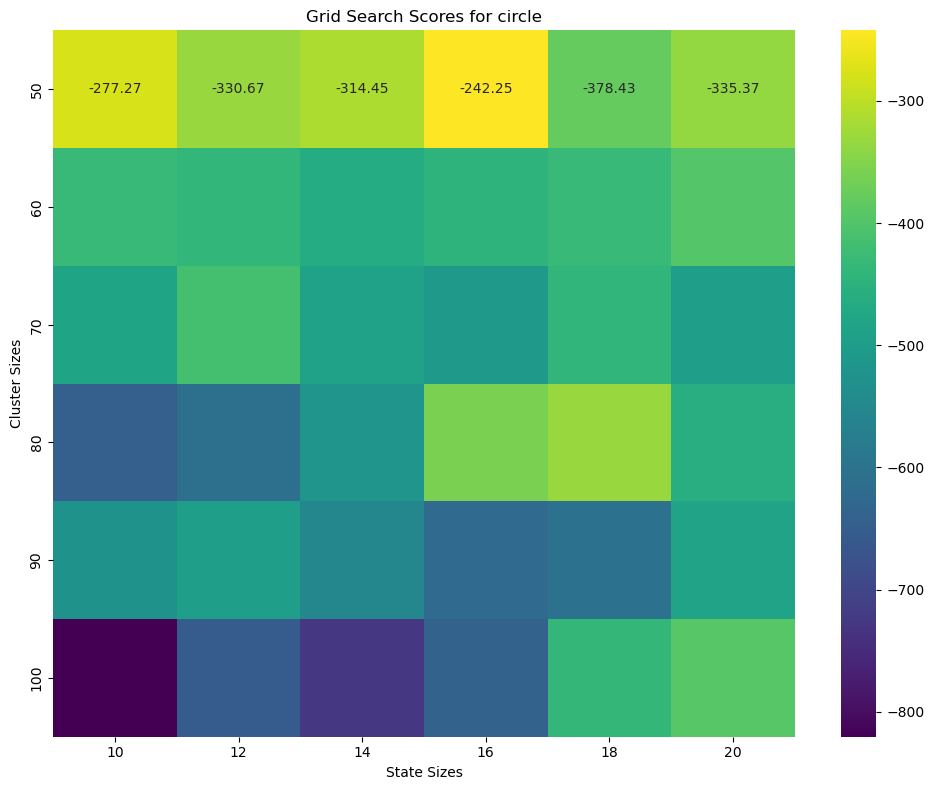

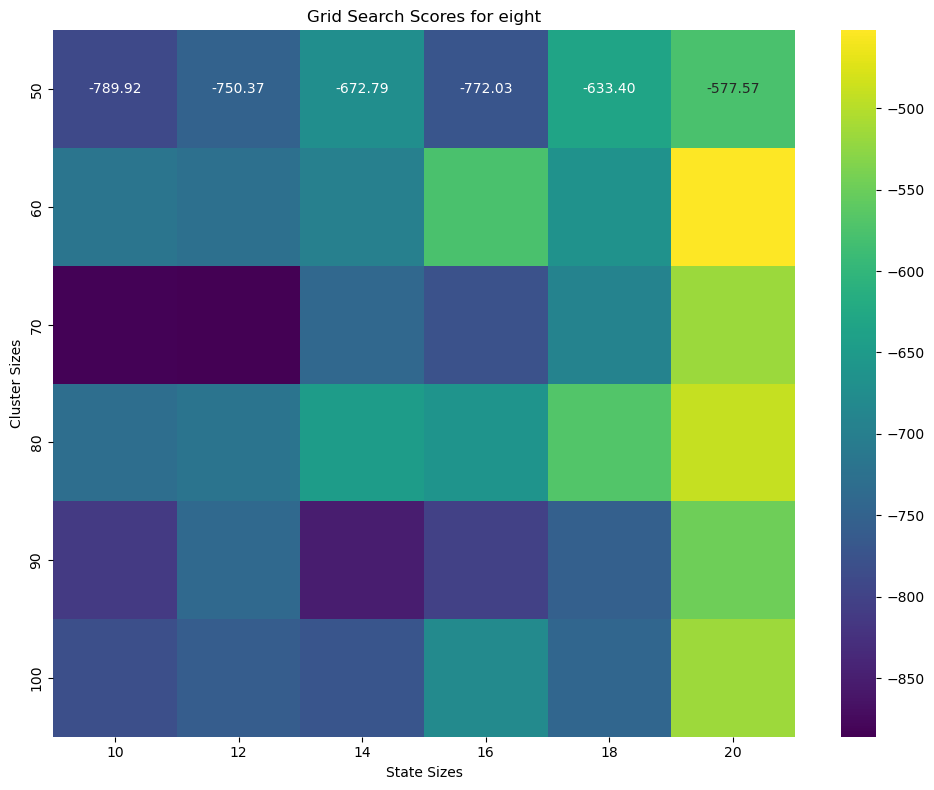

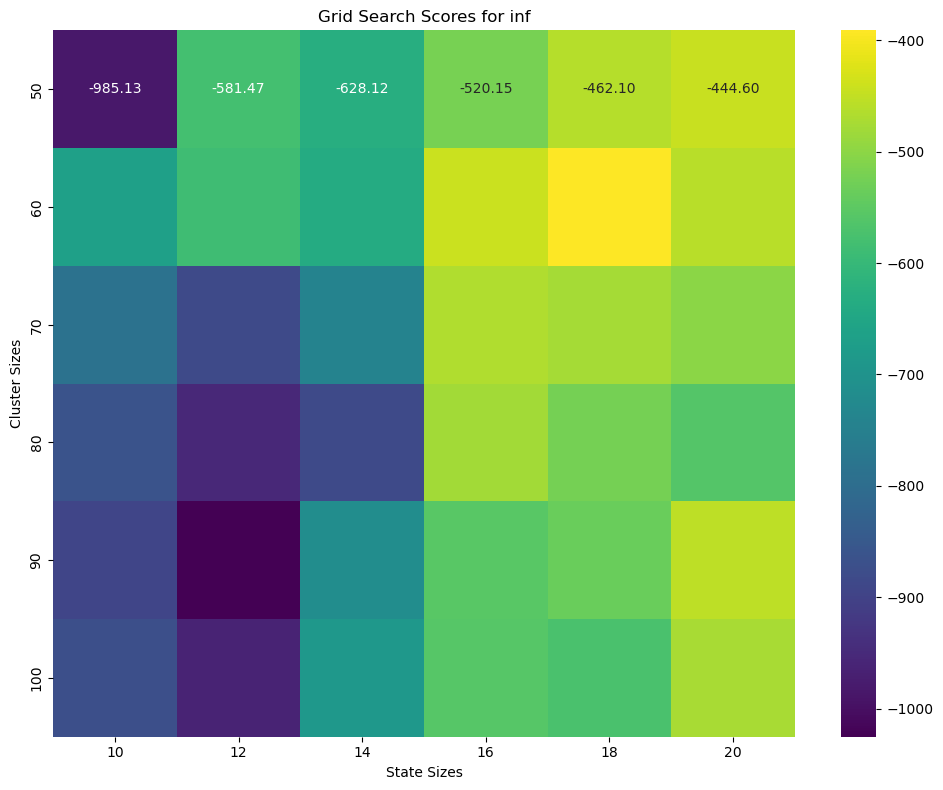

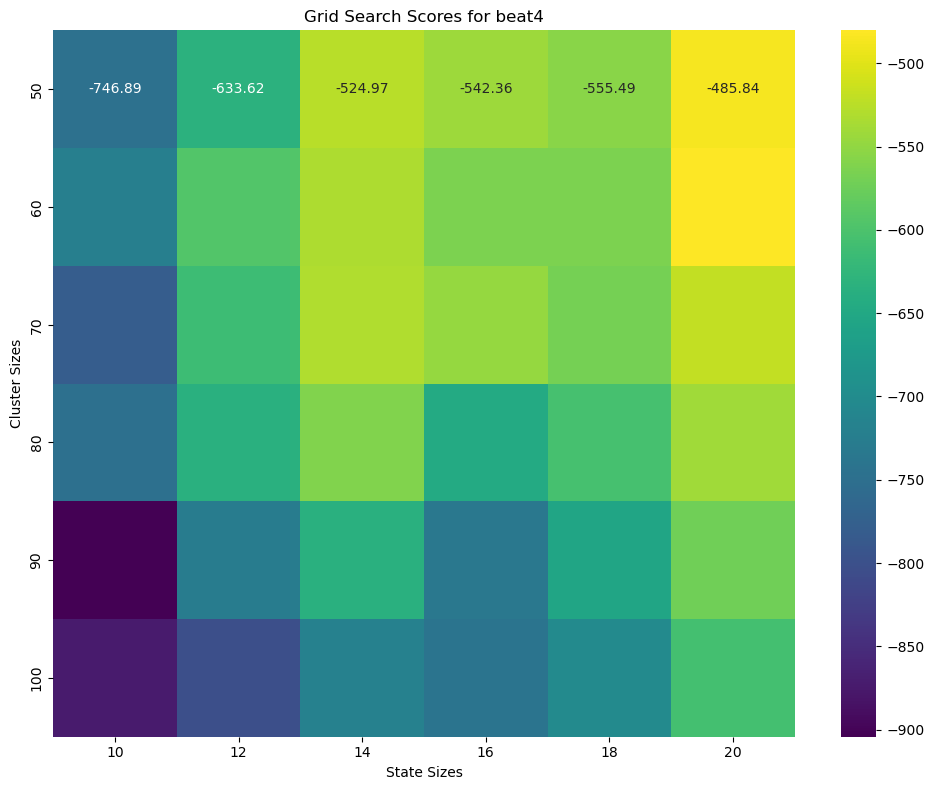

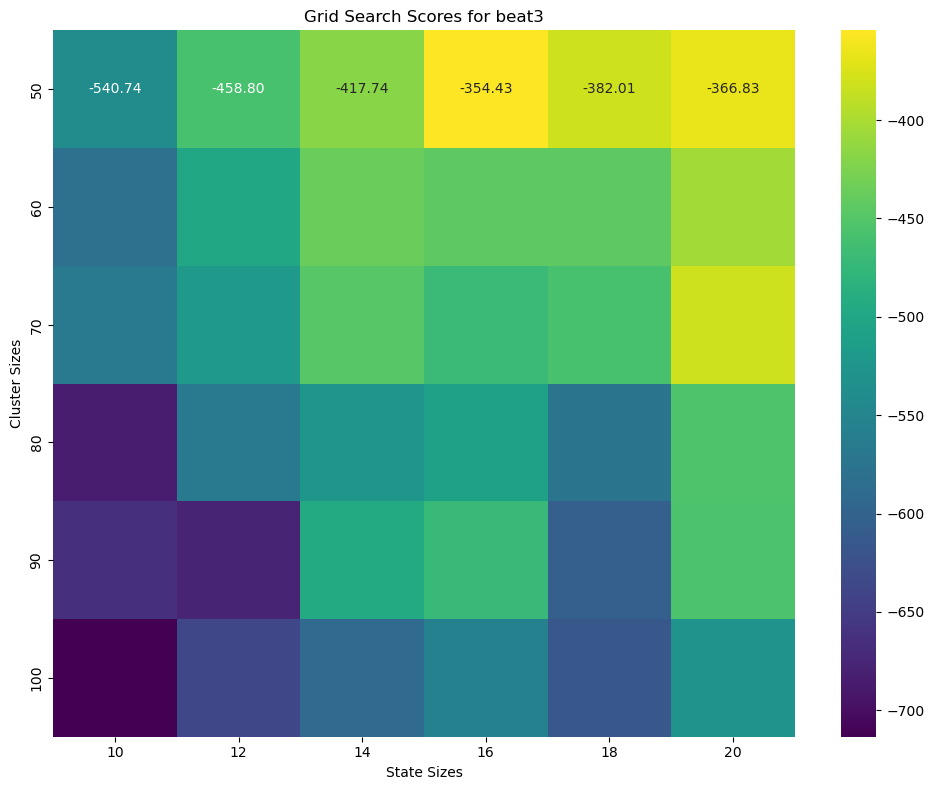

In [14]:
#### Grid search over M and S hyperparams plotting over VAL scores ####
# used https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap and seaborn docs as reference
for motion, hpm_motion in hyperparam_models_dict.items():
    cluster_sizes = sorted(hpm_motion.keys())
    state_sizes = sorted(set(key for subdict in hpm_motion.values() for key in subdict))

    scores = np.zeros((len(cluster_sizes), len(state_sizes)))

    # fill 2D array with scores
    for i, cluster_size in enumerate(cluster_sizes):
        for j, state_size in enumerate(state_sizes):
            model = hpm_motion[cluster_size][state_size]
            scores[i, j] = predict_log_likelihood(A=model[0],B=model[1], pi=model[2], O=val_emissions_gridsearch[cluster_size][motion])
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(scores, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=state_sizes, yticklabels=cluster_sizes, ax=ax)
    ax.set_title(f"Grid Search Scores for {motion}")
    ax.set_xlabel("State Sizes")
    ax.set_ylabel("Cluster Sizes")
    plt.tight_layout()
    plt.savefig(f'IMU-train-visuals/Grid-Search/{motion}_Val_gridsearch.png')

Incorrect prediction for M = 90 and S = 16! 
Expected: beat4 	 Actual: beat3



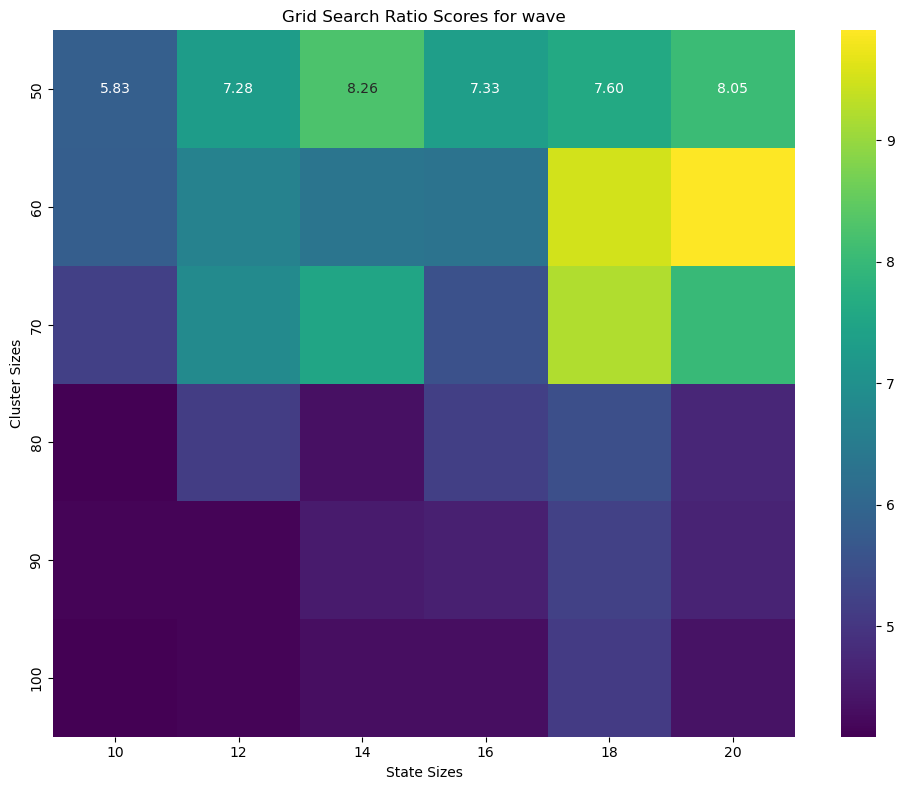

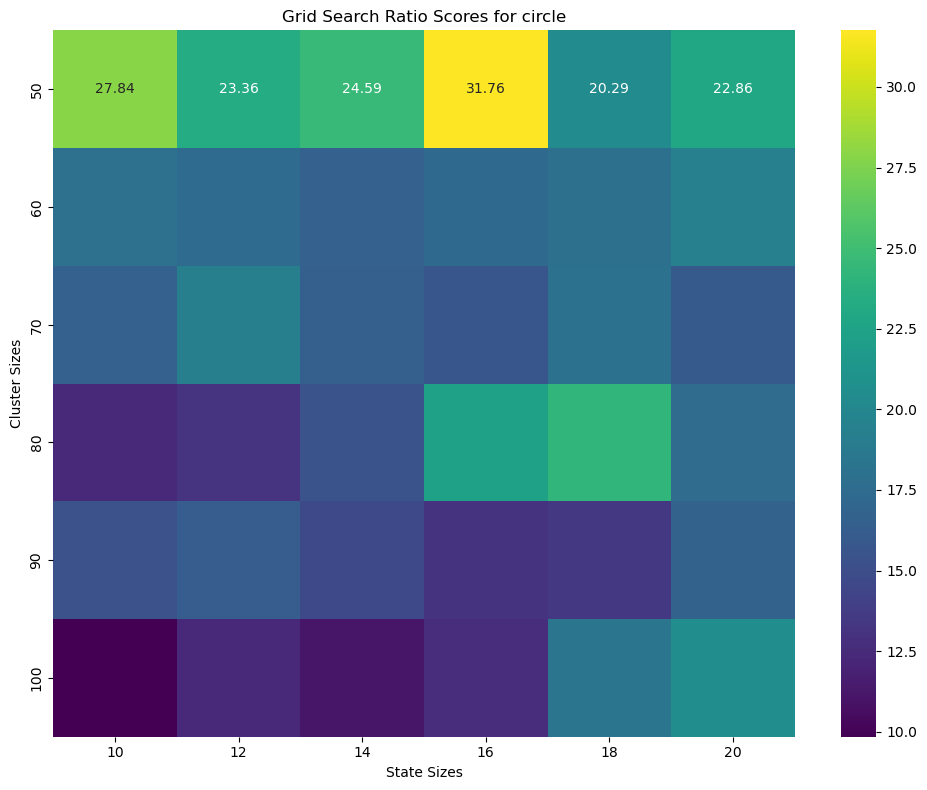

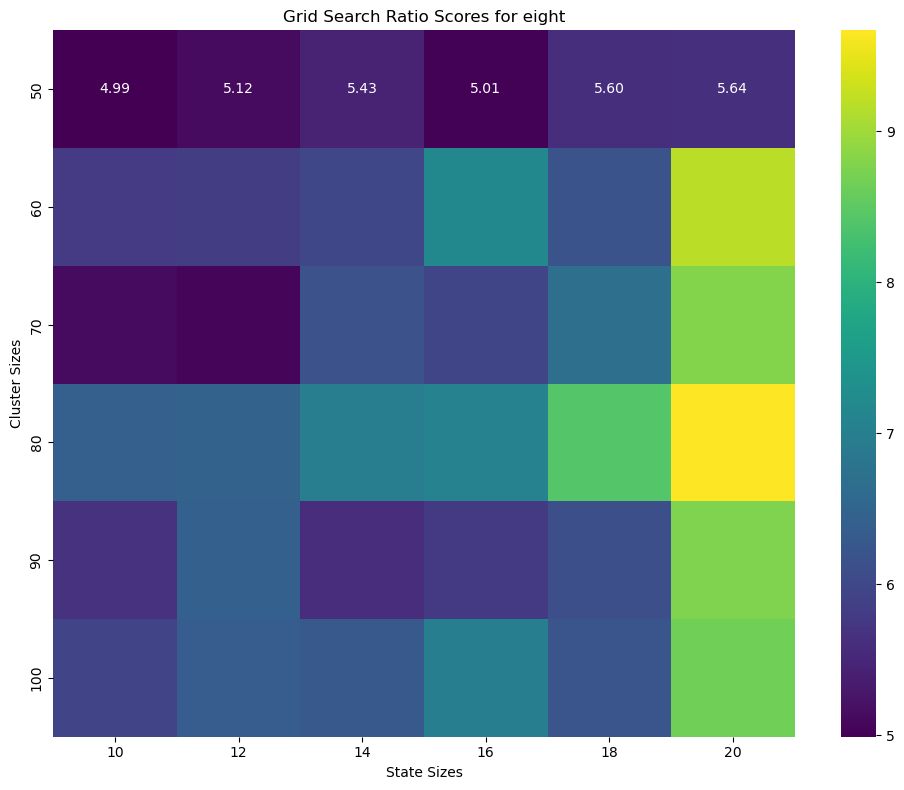

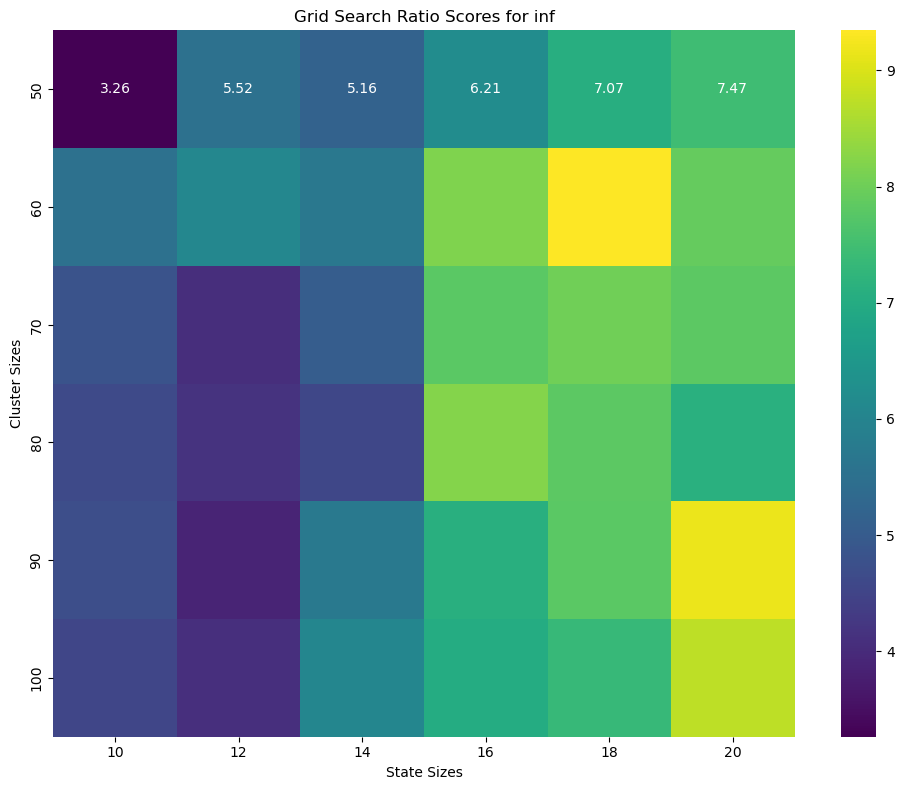

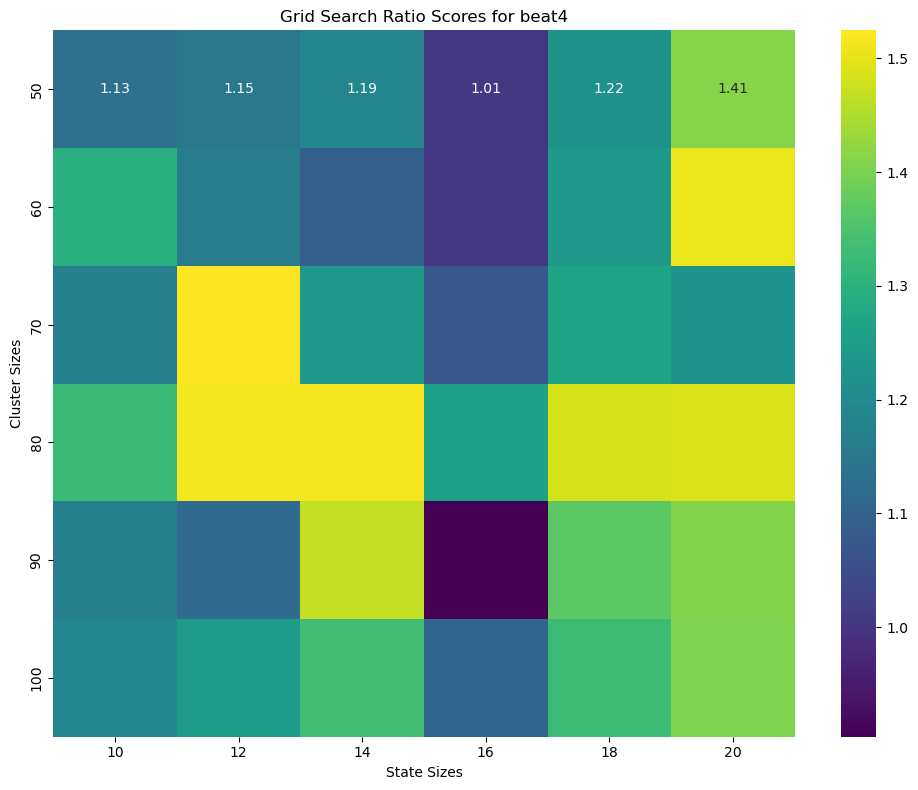

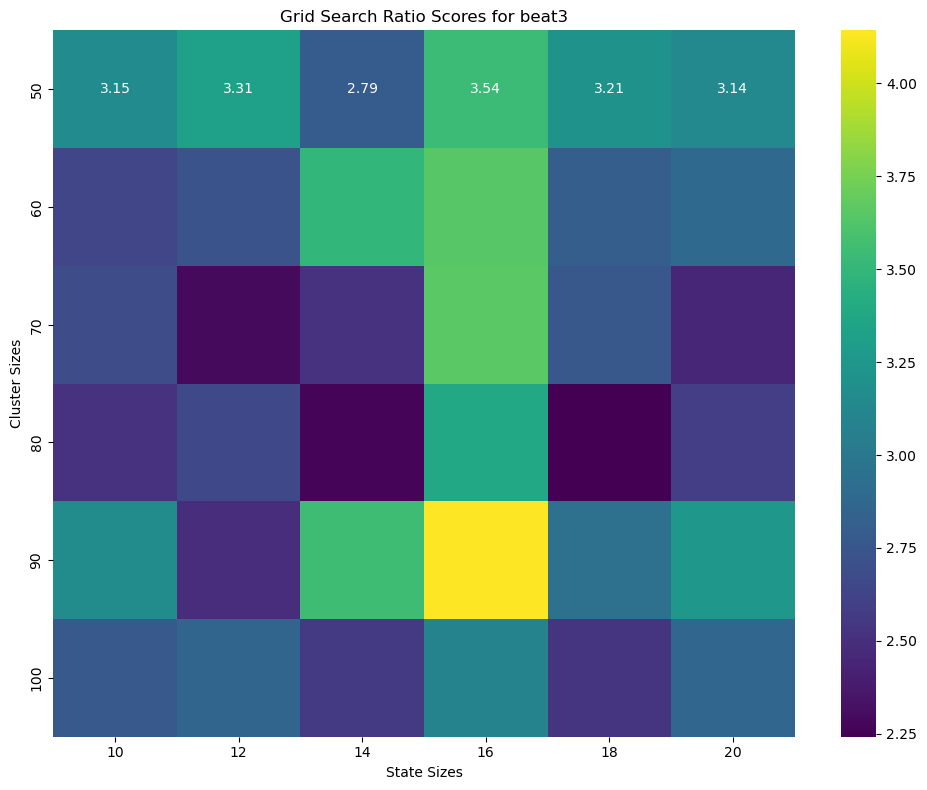

In [13]:
#### Compute RATIO SCORE for Grid search over M and S hyperparams plotting over VAL scores ####
# used https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap and seaborn docs as reference
for motion, hpm_motion in hyperparam_models_dict.items():
    cluster_sizes = sorted(hpm_motion.keys())
    state_sizes = sorted(set(key for subdict in hpm_motion.values() for key in subdict))

    scores = np.zeros((len(cluster_sizes), len(state_sizes)))

    # fill 2D array with scores
    for i, cluster_size in enumerate(cluster_sizes):
        for j, state_size in enumerate(state_sizes):
            # actually straight up doing all the predictions here as well, why not
            model = hpm_motion[cluster_size][state_size]
            correct_score = predict_log_likelihood(A=model[0],B=model[1], pi=model[2], O=val_emissions_gridsearch[cluster_size][motion])
            
            predictions = []
            for candidate_motion in hyperparam_models_dict.keys():
                predictions.append((candidate_motion, \
                        predict_log_likelihood(A=model[0],B=model[1], pi=model[2], O=val_emissions_gridsearch[cluster_size][candidate_motion])))
            predictions = [(model_name, float('-inf') if np.isnan(ll) else ll) for model_name, ll in predictions]
            predictions.sort(key= lambda x: -x[1])

            ## Computing the ratio of the correct prediction score with the next best one (next best as numerator) (or highest scoring if incorrect prediciton)
            if predictions[0][0] == motion:
                # case where prediction is correct
                ratio = predictions[1][1] / correct_score
            else:
                print(f"Incorrect prediction for M = {cluster_size} and S = {state_size}! \nExpected: {motion} \t Actual: {predictions[0][0]}\n")
                ratio = predictions[0][1] / correct_score
            scores[i, j] = ratio
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(scores, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=state_sizes, yticklabels=cluster_sizes, ax=ax)
    ax.set_title(f"Grid Search Ratio Scores for {motion}")
    ax.set_xlabel("State Sizes")
    ax.set_ylabel("Cluster Sizes")
    plt.tight_layout()
    plt.savefig(f'IMU-train-visuals/Grid-Search/{motion}_RatioScore_gridsearch.png')

In [14]:
### Saving all the grid search models ###
for M in Cluster_sizes:
    for S in State_sizes:
        with open(f'HMM-models/model_{M}clusters_{S}states.pkl', 'wb') as f:
            new_dict = {}
            for motion, motion_dict in hyperparam_models_dict.items():
                new_dict[motion] = motion_dict[M][S]
            pickle.dump(new_dict, f)

In [25]:
print(models_dict)

{'circle': (array([[9.25491392e-01, 9.81597517e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.01840248e-01, 1.08902993e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 8.91097007e-01, 9.99999693e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.07069484e-07,
        1.03988144e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0